In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow.keras
from tensorflow.keras.models import Sequential , Model , load_model
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , Input , Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img , img_to_array
from tensorflow.keras.optimizers import Adam , SGD , RMSprop
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from tensorflow.keras import backend as k

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os
import glob

import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

2022-06-20 10:21:26.256909: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-06-20 10:21:26.257018: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
print(len(os.listdir("../input/cell-images-for-detecting-malaria/cell_images/Parasitized")))

13780


In [3]:
print(len(os.listdir("../input/cell-images-for-detecting-malaria/cell_images/Uninfected")))

13780


In [4]:
image_directory = '../input/cell-images-for-detecting-malaria/cell_images'
SIZE = 150
dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
label = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

parasitized_images = os.listdir(image_directory + '/Parasitized/')
for i, image_name in enumerate(parasitized_images):    #Remember enumerate method adds a counter and returns the enumerate object
    
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + '/Parasitized/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(0)

#Iterate through all images in Uninfected folder, resize to 64 x 64
#Then save into the same numpy array 'dataset' but with label 1

uninfected_images = os.listdir(image_directory + '/Uninfected/')
for i, image_name in enumerate(uninfected_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + '/Uninfected/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(1)

dataset = np.array(dataset)
label = np.array(label)

In [8]:
from sklearn.model_selection import train_test_split
#from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(dataset, label,test_size=0.7, shuffle = True, random_state = 0)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,test_size=0.4, random_state= 0)
# X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.20, random_state = 0)

In [6]:
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512))#, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
print(model.summary())
opt = Adam(lr=0.0001,decay=1e-5)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

2022-06-20 10:24:14.497729: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-20 10:24:14.501323: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-06-20 10:24:14.501387: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-20 10:24:14.501425: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (49022e449760): /proc/driver/nvidia/version does not exist
2022-06-20 10:24:14.503763: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [9]:
len(X_train) , len(X_val)

(4960, 3307)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=200),
         steps_per_epoch=len(X_train) // 200, 
         epochs = 10,
         validation_data=datagen.flow(X_val, y_val, batch_size=150),
         validation_steps=len(X_val) // 150)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-06-20 10:27:35.678307: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-20 10:27:35.684050: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


Epoch 1/10
24/24 [==============================] - 183s 8s/step - loss: 0.6831 - acc: 0.5532 - val_loss: 0.6475 - val_acc: 0.6470
Epoch 2/10
24/24 [==============================] - 170s 7s/step - loss: 0.6386 - acc: 0.6437 - val_loss: 0.6218 - val_acc: 0.6658
Epoch 3/10
24/24 [==============================] - 171s 7s/step - loss: 0.6037 - acc: 0.6899 - val_loss: 0.6073 - val_acc: 0.6833
Epoch 4/10
24/24 [==============================] - 170s 7s/step - loss: 0.6051 - acc: 0.6923 - val_loss: 0.5965 - val_acc: 0.6885
Epoch 5/10
24/24 [==============================] - 179s 8s/step - loss: 0.5916 - acc: 0.6927 - val_loss: 0.5866 - val_acc: 0.6970
Epoch 6/10
24/24 [==============================] - 172s 7s/step - loss: 0.5731 - acc: 0.7117 - val_loss: 0.5645 - val_acc: 0.7158
Epoch 7/10
24/24 [==============================] - 172s 7s/step - loss: 0.5502 - acc: 0.7355 - val_loss: 0.5286 - val_acc: 0.7524
Epoch 8/10
24/24 [==============================] - 170s 7s/step - loss: 0.5129 - a

In [ ]:
# model_checkpoint = ModelCheckpoint('unet_camvid.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
# model.fit_generator(train_generator_fn(),
#                     validation_data=val_generator_fn(),
#                     steps_per_epoch=steps_per_epoch,
#                     validation_steps=validation_steps,
#                     epochs=epochs,
#                     callbacks=[model_checkpoint])

In [11]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=200)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(X_test[:3])
print("predictions shape:", predictions.shape)

Evaluate on test data


2022-06-20 10:58:37.498950: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1302142500 exceeds 10% of free system memory.


97/97 [==============================] - 147s 2s/step - loss: 24.4732 - acc: 0.8539
test loss, test acc: [24.473224639892578, 0.8538696765899658]
Generate predictions for 3 samples
predictions shape: (3, 1)


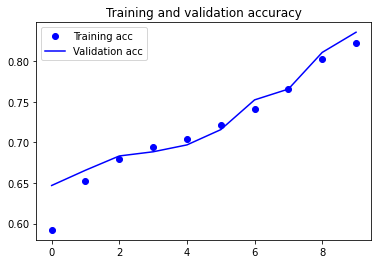

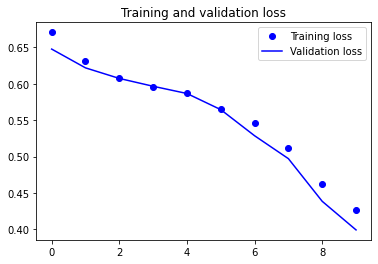

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 0s 0us/step


In [14]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [15]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)              

In [21]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint

train_datagen = ImageDataGenerator(
      #rescale=1./255,
      preprocessing_function=preprocess_input,
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)#rescale=1./255) # Issue: https://github.com/fchollet/deep-learning-with-python-notebooks/issues/21

train_generator = train_datagen.flow(
        # This is the target directory
        X_train,
        y_train,
        batch_size=100)

validation_generator = test_datagen.flow(
        X_val,
        y_val,
        batch_size=100)

opt = Adam(lr=0.0001,decay=1e-5)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['acc'])

model_checkpoint = ModelCheckpoint('binary_classification.hdf5', monitor='val_loss',verbose=1, save_best_only=True)

history = model.fit_generator(
      train_generator,
      steps_per_epoch=len(X_train) // 100,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=len(X_val) // 100,
      callbacks=[model_checkpoint])

Epoch 1/15
49/49 [==============================] - 1095s 22s/step - loss: 0.7025 - acc: 0.5961 - val_loss: 37.1060 - val_acc: 0.5815

Epoch 00001: val_loss improved from inf to 37.10598, saving model to binary_classification.hdf5
Epoch 2/15
49/49 [==============================] - 1081s 22s/step - loss: 0.3190 - acc: 0.8858 - val_loss: 28.2445 - val_acc: 0.5491

Epoch 00002: val_loss improved from 37.10598 to 28.24449, saving model to binary_classification.hdf5
Epoch 3/15
49/49 [==============================] - 1081s 22s/step - loss: 0.2712 - acc: 0.9068 - val_loss: 43.0032 - val_acc: 0.5048

Epoch 00003: val_loss did not improve from 28.24449
Epoch 4/15
49/49 [==============================] - 1093s 22s/step - loss: 0.2405 - acc: 0.9192 - val_loss: 34.2406 - val_acc: 0.5188

Epoch 00004: val_loss did not improve from 28.24449
Epoch 5/15
49/49 [==============================] - 1079s 22s/step - loss: 0.2352 - acc: 0.9195 - val_loss: 34.8619 - val_acc: 0.5958

Epoch 00005: val_loss di

In [22]:
from tensorflow.keras.models import load_model

model = load_model('binary_classification.hdf5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)              

The prediction for this image is:  [[0.23080984]]
The actual label for this image is:  1


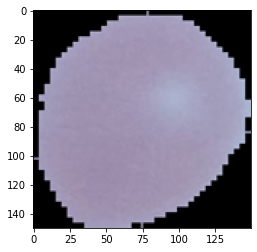

In [23]:
n=24  #Select the index of image to be loaded for testing
img = X_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The prediction for this image is: ", model.predict(input_img))
print("The actual label for this image is: ", y_test[n])

In [ ]:
mythreshold=0.5
from sklearn.metrics import confusion_matrix

y_pred = (model.predict(X_test)>= mythreshold).astype(int)
cm=confusion_matrix(y_test, y_pred)  
print(cm)

In [ ]:
from sklearn.metrics import roc_curve
y_preds = model.predict(X_test).ravel()

fpr, tpr, thresholds = roc_curve(y_test, y_preds)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [ ]:
import pandas as pd
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 

In [ ]:
from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)